# Trennung von Signal und Hintergrund - Einlesen der Rohdaten

Die Daten sind in zwei Dateien aufgeteilt.
- In der ersten Datei (`fn_signal`) sind Wellen aufgezeichnet, während eine radioaktve Quelle in der Nähe des Detektors stand.
Dies sind somit Beispieldaten für Signale (*signal*).
- In der zweiten Datei (`fn_background`) sind Wellen aufgezeichnet, während keine radioaktive Quelle in der Nähe des Detektors stand.
Damit wird also der Hintergrund (*background*) aufgezeichnet.
Trotzdem können Signale empfangen werden, da der Detektor nicht abgeschirmt ist.

Die Daten sind in einer `Yaml`-Datei gespeichert. 
Daher werden diese Daten eingelesen und anschließend in einer `CSV`-Datei (`fn_outCSV`) gespeichert.
Gespeichert werden dabei die Rohdaten als Werte der Wellen an 100 Positionen, so wie es die Datenaufzeichnung ausgibt. 
Dazu kommt ein Label für **Signal** (`LABEL_SIGNAL`) oder **Hintergrund** (`LABEL_BACKGROUND`), je nachdem von welcher Datei der Datensatz kommt.
Damit werden in einer Datendatei Signal und Hintergrund gespeichert.

Bei dieser Übertragung wird eine Filterung vorgenommen.
Die folgenden Wellen werden nicht in die `CSV`-Datei ausgegeben:
1. Von den Hintergrunddaten werden diejenigen Wellen nicht berücksichtigt, 
deren größter (negativer) Impuls größer als eine vorgegebene Schwelle (`threshold`) ist.
Diese Wellen können potenziell Signale sein, da der Detektor nicht abgeschirmt ist. Wird als Wert für die Schwelle 0 angegeben, 
dann werden bezüglich des Schwellwertes keine Instanzen eliminiert.
2. Wellen (Signal und Hintergrund), deren maximaler Impuls zu sehr am Rand der Aufzeichnung sind,
werden ebenfalls nicht berücksichtigt. Der entsprechende Parameter (`center_distance`) bestimmt den maximalen Abstand 
(als Faktor von der Anzahl der Punkte der gesamten Welle) des maximalen (negativen) Impulses vom rechten und vom linken Rand.
Diese Wellen sind potentiell Fehler in der Aufzeichnung.

Damit ist die Datenmenge weitgehend bereinigt.

Grundlegende Parameter für den Ablauf

In [1]:
fn_signal = "data/rawSignal.zip"
fn_background = "data/rawBackground.zip"
fn_outCSV = "data/sbDataComplete.csv"

LABEL_SIGNAL = 1
LABEL_BACKGROUND = -1

threshold = 8000
center_distance = 0.2

Parameter zur Steuerung des Programms

In [2]:
# --- parameters to controll the number of instances (waves of signals 
#     and background), which are transfered to the output
#     if number is equal to 0, all instancses are transfered
#     if number is unequal 0, the number of transfred instanced is limited
n_inst_signal = 0
n_inst_background = 0

# --- maximum number of eliminated waves (signal / background) 
#     which are showed as plot
max_show_rejected = 5

Import benötigter Module

In [3]:
# --- imports
import matplotlib.pyplot as plt
import numpy as np
import yaml
import zipfile

from tools_show import show_SignalWaveForm_single

Definition einiger Hilfsroutinen zum Lesen der Eingabedateien und zur Bearbeitung der Instanzen von Wellen.

Öffnen einer Datei und dabei feststellen, ob es eine Zip-Datei ist oder nicht.
Rückgabewerte: ein Handle auf die geöffnete Datei und ein Kennzeichen, ob es sich um eine Zip-Datei handelt.

In [4]:
def open_file (fname):
    print ('    input from file ' + fname)

    try:
        if (fname.split ('.')[-1] == 'zip'):
            # --- read from zip file
            zipmode = True
            zf = zipfile.ZipFile (fname, 'r')
            fnam = zf.namelist ()[0]  # first file
            print('    reading from packed file ' + fnam)
            f = zf.open(fnam)
        else:
            # --- read from unpacked file
            zipmode = False
            f = open(fname, 'r')
    except Exception as e:
        print(' !!! failed to open input file ' + fname + ": " + str(e))
        exit(1)
    return f, zipmode

Aus der Eingabedatei einen Textblock lesen

In [5]:
# --- helper function
def readblock (f, zipmode):
    # read data sequentially from input file
    #   end of block marked by ']]\n'
    txt = ''
    while True:
        if zipmode:
            _l = f.readline().decode('utf-8')
        else:
            _l = f.readline()
        if not _l:  # end of file
            return ''
        txt += _l
        if _l[-2:-1] == ']': # end of block
            return txt

Die Routine `expand_data` ergänzt die Daten (`data`) der Welle mit dem entsprechenden Label (`label`).
Dabei werden die Instanzen nicht berücksichtigt, welche die Kriterien bezüglich
des Schwellwertes oder der zentralen Lage des Impulses nicht erfüllen.

In [6]:
LABEL_NO_PROBLEM = 0
LABEL_NOT_CENTERED = 1
LABEL_IMPULS = 2    # background: to high, signal: to low

def expand_data (data, label, threshold, center_distance):
    """
    out:
    - boolean label whether the instance is okay (True) or to eliminate (False)
    - the expanded data as (original data plus label)
    - label for a problem
    - description of the problem 
    """
    val_impulse = -np.min (data)
    pos_impulse = np.argmin (data)
    len_data = len (data)
    data_expand = data + [label]    

    problem_pos = (pos_impulse < len_data * center_distance) \
               or (pos_impulse > len_data * (1 - center_distance))
    problem_val_b = (label == LABEL_BACKGROUND) and (val_impulse > threshold)
    problem_val_s = (label == LABEL_SIGNAL) and (val_impulse < threshold)
    if problem_pos:
        return False, data_expand, LABEL_NOT_CENTERED, \
            "max impulse not centered"
    elif problem_val_b:
        return False, data_expand, LABEL_IMPULS, \
            "background, impulse to high"
    elif problem_val_s:
        return True, data_expand, LABEL_IMPULS, \
            "signal, impulse to low"
    else:
        return True, data_expand, LABEL_NO_PROBLEM, ""

Lesen der Rohdaten aus einer Eingabedatei und Steuerung der Bearbeitung

In [7]:
def read_rawData (f, zipmode, n_ins=0, label=0, threshold=0,\
                  center_distance=0.0):
    list_of_data = []

    if (n_ins <= 0):
        n_ins = 9999999
# --- read first block from file
    try:
        txt = readblock (f, zipmode)
        obj = yaml.load (txt, Loader=yaml.Loader)
    except Exception as e:
        print ('     failed reading from yaml file : ' + str(e))
        exit (1)

# --- start read loop
    finished = False
    cnt_inp = 0
    cnt_out = 0
    cnt_rejected = 0
    cnt_notcentered = 0
    cnt_s_lowpuls = 0
    cnt_b_highpuls = 0
    figsize=(4.,4.)

    while not (finished):
        data = obj ['data']
        if (cnt_inp % 1000 == 0):
            print (".", end = '')
        if (cnt_inp >= n_ins):
            print ("    max number of instances!")
            finished = True  # end of file
        else:
            for d in data:
                cnt_inp += 1
                okay, d_expand, label_problem, remark = expand_data (d, label, threshold, center_distance)
                if okay:
                    cnt_out += 1
                    list_of_data.append (d_expand)
                    if (label_problem == LABEL_IMPULS):
                        cnt_s_lowpuls += 1
                else:
                    cnt_rejected += 1
                    if (cnt_rejected <= max_show_rejected):
                        show_SignalWaveForm_single (d, remark, figsize=figsize)
                    if (label_problem == LABEL_NOT_CENTERED):
                        cnt_notcentered += 1
                    if (label_problem == LABEL_IMPULS):
                        cnt_b_highpuls += 1
            txt = readblock (f, zipmode)
            if txt == '':
                print ("    end of file!")
                finished = True  # end of file
            else:
                obj = yaml.load ('data: \n' + txt, Loader=yaml.Loader)

    print ("    number of objects read: ", cnt_inp)
    print ("    number of objects out : ", cnt_out)
    print ("      therefore signal with low pulse : ", cnt_s_lowpuls)
    print ("    number of rejected objects: ", cnt_rejected)
    print ("      therefore background with high pulse : ", cnt_b_highpuls)
    print ("      therefore waves not centered         : ", cnt_notcentered)
    f.close ()
    return (np.array (list_of_data))


Einlesen der Signal-Daten

Einige Wellen, welche nicht berücksichtigt werden, werden grafische ausgegeben.
In der Titelzeile steht die Begründung, wieso die Welle nicht übertragen wird.

    input from file data/rawSignal.zip
    reading from packed file rawSignal_241018-1510.yml
.

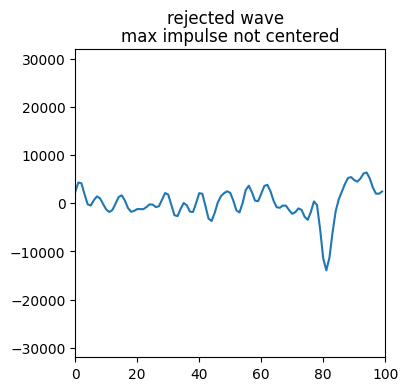

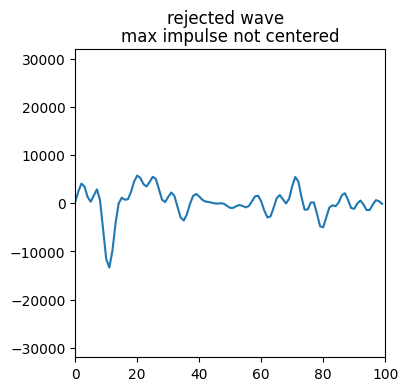

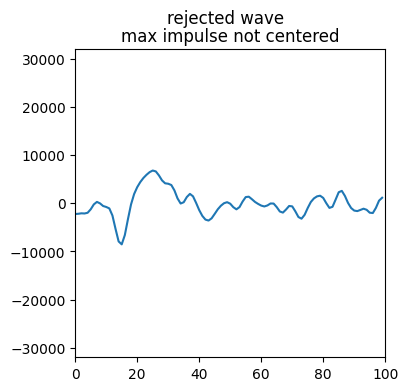

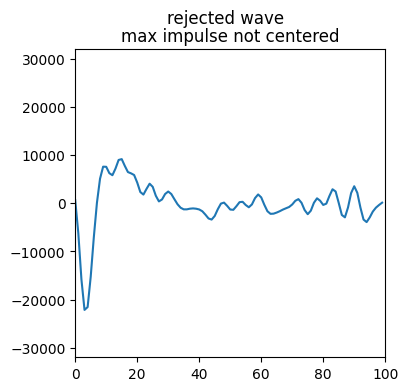

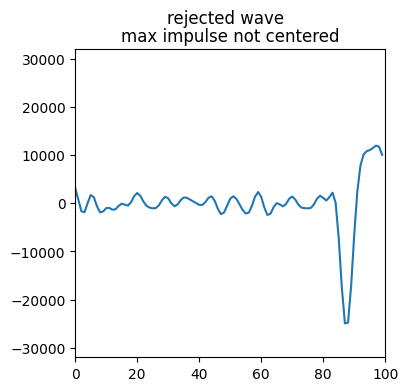

...............    end of file!
    number of objects read:  15250
    number of objects out :  14666
      therefore signal with low pulse :  0
    number of rejected objects:  584
      therefore background with high pulse :  0
      therefore waves not centered         :  584
(14666, 101)


In [8]:
# --- read data - signal
f, zipmode = open_file (fn_signal)
data_signal = read_rawData (f, zipmode, n_ins=n_inst_signal, threshold=threshold, \
                            center_distance=center_distance, label=LABEL_SIGNAL)
print (data_signal.shape)

Einlesen der Hintergrund-Daten

    input from file data/rawBackground.zip
    reading from packed file rawBackground_241018-1818.yml
.

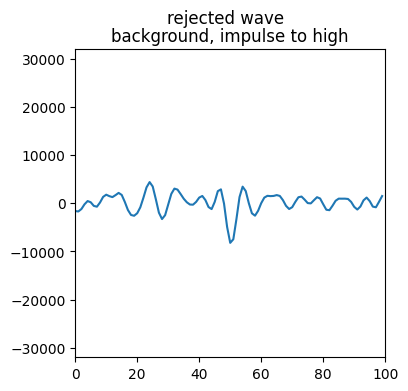

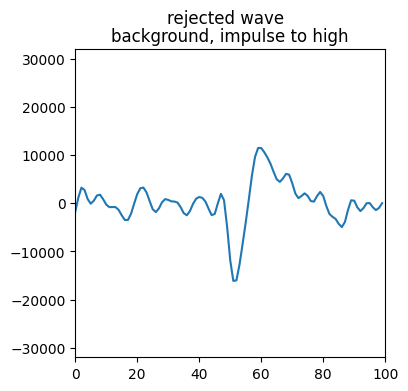

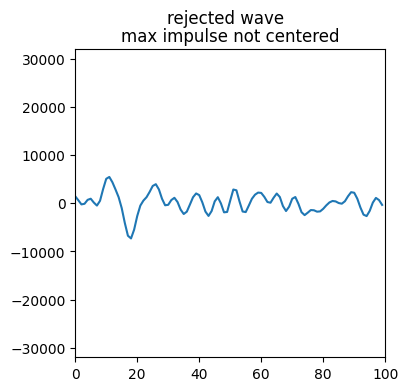

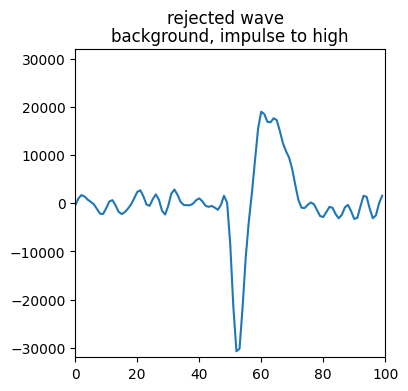

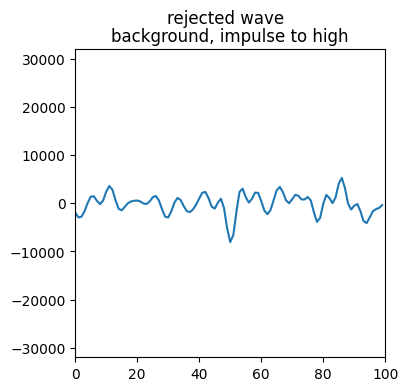

..........    end of file!
    number of objects read:  10817
    number of objects out :  9088
      therefore signal with low pulse :  0
    number of rejected objects:  1729
      therefore background with high pulse :  1395
      therefore waves not centered         :  334


In [9]:
# --- read data - background
f, zipmode = open_file (fn_background)
data_background = read_rawData (f, zipmode, n_ins=n_inst_background, threshold=threshold, \
                                center_distance=center_distance, label=LABEL_BACKGROUND)

Ausgabe der gesamten Daten (Signal- und Hintergrund-Daten) in einer CSV-Datei.
Die CSV-Datei enthält in der ersten Zeile die Headerinformationen.

In [10]:
def get_header (n):
    header = ""
    for ind in range (n - 1):
        new_text = "P" + str(ind) + ";"
        header = header + new_text
    return header

# --- save data as CSV-file
print ('    output to file ' + fn_outCSV)

print ("signal      : ", data_signal.shape)
print ("background  : ", data_background.shape)
data_sb = np.concatenate ((data_signal, data_background), axis = 0)
print ("output data : ", data_sb.shape)
fmt = 100 * ['%.3e'] + ['%.0f']
header = get_header (data_sb.shape [1]) + "LABEL"
np.savetxt (fn_outCSV, data_sb, fmt=fmt, delimiter=";", \
            header=header, comments='')

    output to file data/sbDataComplete.csv
signal      :  (14666, 101)
background  :  (9088, 101)
output data :  (23754, 101)


Ende